In [1]:
import json
import os
import ast # For safely evaluating string representations of lists
from pathlib import Path # Use Pathlib for cleaner path handling
import sys

# Data analysis and visualization imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm # For accessing color maps
import sympy
from typing import Optional
import re

# Jupyter/IPython specific imports
from IPython.display import display # For better rendering of DataFrames

In [2]:
# --- Configuration ---

# Set display options for pandas DataFrames
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Plotting style and settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For higher resolution plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.tab10.colors) # Use tab10 color cycle

# Define base path (as requested)
user = os.environ.get("USER", "default_user")
BASE_RESULTS_PATH = Path(f"/home/users/ntu/{user}/slimsc/prune/results")

SLIMSC_PRUNE_DIR = BASE_RESULTS_PATH.parent # This should resolve to .../slimsc/prune/

if SLIMSC_PRUNE_DIR.is_dir():
    if str(SLIMSC_PRUNE_DIR) not in sys.path:
        sys.path.insert(0, str(SLIMSC_PRUNE_DIR)) # Add to the beginning of the path
        print(f"Added '{SLIMSC_PRUNE_DIR}' to sys.path for module imports.")
else:
    print(f"Warning: Project directory '{SLIMSC_PRUNE_DIR}' not found. HMMT utils import might fail.")

# --- Import HMMT utility functions ---
try:
    from utils.hmmt_utils import normalize_latex_expression, to_sympy, is_equivalent
    print("Successfully imported HMMT utility functions from utils.hmmt_utils.")
except ImportError as e:
    print(f"ERROR: Could not import HMMT utility functions: {e}")
    print(f"Please ensure that '{SLIMSC_PRUNE_DIR / 'utils' / 'hmmt_utils.py'}' exists")
    print(f"and that '{SLIMSC_PRUNE_DIR / 'utils' / '__init__.py'}' (can be empty) also exists.")
    print("The script will likely fail if these functions are not available.")
    # Define dummy functions that will raise an error if called, to make it clear if import failed
    def _raise_import_error(*args, **kwargs):
        raise ImportError("HMMT utility functions were not imported successfully. Cannot proceed.")
    normalize_latex_expression = _raise_import_error
    to_sympy = _raise_import_error
    is_equivalent = _raise_import_error

# Define the specific SC runs to analyze for each model and dataset
# Structure: {model_name: {dataset_name: [run_subdirectories]}}
SC_RUNS_TO_ANALYZE = {
    "QwQ-32B": {
        "aime": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            # "sc_32_control",
            "sc_64_control",
        ],
        "gpqa_diamond": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            "sc_32_control",
            "sc_64_control",
        ],
        "aqua_rat": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            "sc_32_control",
            "sc_64_control",
        ],
        "hmmt": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            "sc_32_control",
            "sc_64_control",
        ],
    },
    "R1-Distill-Qwen-14B": {
        "aime": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            "sc_32_control",
            "sc_64_control",
        ],
        "gpqa_diamond": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            "sc_32_control",
            "sc_64_control",
        ],
        "aqua_rat": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            "sc_32_control",
            "sc_64_control",
        ],
        "hmmt": [
            "sc_2_control",
            "sc_8_control",
            "sc_16_control",
            "sc_32_control",
            "sc_64_control",
        ],
    },
}

# Output directory for plots
PLOTS_OUTPUT_DIR = Path(f"/home/users/ntu/{user}/slimsc/prune/visualization/plots")

Added '/home/users/ntu/chaanan0/slimsc/prune' to sys.path for module imports.


/home/users/ntu/chaanan0/miniconda3/envs/vllm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully imported HMMT utility functions from utils.hmmt_utils.


In [3]:
# --- Helper Function for Full Data Metric Calculation ---

def clean_answer(ans):
    """Cleans an answer for consistent comparison."""
    s = str(ans).strip()
    try:
        return float(s)
    except ValueError:
        if len(s) > 1 and s[0].isalpha() and not s[1].isalnum():
            return s[0].upper()
        return s.upper()

def calculate_metrics_from_full_data(csv_path: Path) -> dict:
    """
    Calculates % Correct Answer Voted (Overall Accuracy) and
    % Correct in Individual Answer Candidates from evaluation_summary.csv.
    Uses HMMT-specific comparison for 'hmmt' dataset.
    """
    results = {
        "overall_accuracy": float("NaN"),
        "perc_correct_in_individual_answers": float("NaN"),
    }

    if not csv_path.exists():
        print(f"Warning: Evaluation summary file not found at {csv_path}")
        return results
    try:
        dataset_name = csv_path.parent.parent.name # Infer dataset_name
        # print(f"Debug: Inferred dataset_name: {dataset_name} from path {csv_path}")

        df = pd.read_csv(csv_path)
        if df.empty:
            print(f"Warning: {csv_path} is empty.")
            return results

        # --- Calculate % Correct Answer Voted (Overall Accuracy) ---
        if 'final_score' in df.columns and not df['final_score'].empty:
            accuracy_from_final_score = pd.to_numeric(df['final_score'], errors='coerce').mean()
            if pd.notna(accuracy_from_final_score):
                results['overall_accuracy'] = accuracy_from_final_score * 100
            else:
                print(f"Warning: 'final_score' in {csv_path.name} contains non-numeric values or all NaNs.")
        else:
            print(f"Warning: 'final_score' column not found or empty in {csv_path.name}.")

        # --- Calculate % Correct in Individual Answer Candidates (Refactored) ---
        if 'individual_answers_str' in df.columns and 'correct_answer' in df.columns:

            def check_if_correct_is_present(row):
                try:
                    correct_answer_val = row['correct_answer']
                    answers_str = row['individual_answers_str']

                    if pd.isna(answers_str) or not str(answers_str).strip():
                        return 0

                    raw_list = ast.literal_eval(str(answers_str))
                    if not isinstance(raw_list, list):
                        return None # Parsing issue

                    if dataset_name == "hmmt":
                        normalized_correct_answer = normalize_latex_expression(str(correct_answer_val))
                        
                        # Normalize all candidate answers
                        normalized_candidate_answers = set() # Use a set for efficient lookup
                        for candidate_ans_latex in raw_list:
                            if pd.notna(candidate_ans_latex):
                                normalized_candidate_answers.add(normalize_latex_expression(str(candidate_ans_latex)))
                        
                        if normalized_correct_answer in normalized_candidate_answers:
                            return 1
                        return 0

                    else:
                        # Non-HMMT datasets: Use existing clean_answer logic
                        cleaned_correct_answer = clean_answer(correct_answer_val)
                        # Create a set of cleaned candidate answers for efficient lookup
                        cleaned_candidate_answers = set()
                        for ans_candidate in raw_list:
                            if pd.notna(ans_candidate):
                                cleaned_candidate_answers.add(clean_answer(ans_candidate))
                        
                        if cleaned_correct_answer in cleaned_candidate_answers:
                            return 1
                        return 0

                except (SyntaxError, ValueError, TypeError) as e:
                    # print(f"Warning: Error parsing 'individual_answers_str' or processing row for '{dataset_name}' in {csv_path.name}: {e}.")
                    return None

            df['correct_is_present'] = df.apply(check_if_correct_is_present, axis=1)
            
            num_valid_rows = df['correct_is_present'].notna().sum()
            if num_valid_rows > 0:
                perc_present_mean = df['correct_is_present'].mean()
                results['perc_correct_in_individual_answers'] = perc_present_mean * 100
            else:
                # print(f"Debug: Individual percentage set to NaN for {csv_path.name} (dataset: {dataset_name}) due to 0 parsable/valid rows.")
                pass # results['perc_correct_in_individual_answers'] remains NaN
        else:
            print(f"Warning: Missing 'individual_answers_str' or 'correct_answer' in {csv_path.name} for dataset '{dataset_name}'.")

    except Exception as e:
        print(f"An unexpected error occurred while processing {csv_path} (dataset: {dataset_name if 'dataset_name' in locals() else 'Unknown'}): {e}")
        results = {k: float("NaN") for k in results}
    return results

In [4]:
# --- Data Collection ---

all_sc_data = []

print("--- Starting Data Collection for SC Runs (Full Data) ---")

for model, datasets in SC_RUNS_TO_ANALYZE.items():
    print(f"\nProcessing model: {model}")
    for dataset, run_names in datasets.items():
        print(f"  Processing dataset: {dataset}")
        for run_name in run_names:
            print(f"    Processing run: {run_name}...")
            run_path = BASE_RESULTS_PATH / model / dataset / run_name
            eval_summary_path = run_path / "evaluation_summary.csv"

            # Extract n_chains from run name
            # Example: "sc_16_control" -> 16
            try:
                parts = run_name.split('_')
                if len(parts) >= 2 and parts[0] == 'sc':
                    n_chains = int(parts[1])
                else:
                    print(f"Warning: Could not extract n_chains from run name: {run_name}. Skipping.")
                    continue
            except PercentageError:
                 print(f"Warning: Could not parse n_chains from run name: {run_name}. Skipping.")
                 continue

            # Calculate metrics from full data
            metrics = calculate_metrics_from_full_data(eval_summary_path)

            # Append results
            run_data = {
                "Model": model,
                "Dataset": dataset,
                "n_chains": n_chains,
                "% Correct Answer Voted (Overall Accuracy)": metrics.get("overall_accuracy", float("NaN")),
                "% Correct Answer Present in Final Candidates": metrics.get("perc_correct_in_individual_answers", float("NaN")),
            }
            all_sc_data.append(run_data)
            # print(f"      Collected data: {run_data}") # Uncomment for detailed logging

print("\n--- Finished Data Collection ---")

--- Starting Data Collection for SC Runs (Full Data) ---

Processing model: QwQ-32B
  Processing dataset: aime
    Processing run: sc_2_control...
    Processing run: sc_8_control...
    Processing run: sc_16_control...
    Processing run: sc_64_control...
  Processing dataset: gpqa_diamond
    Processing run: sc_2_control...
    Processing run: sc_8_control...
    Processing run: sc_16_control...
    Processing run: sc_32_control...
    Processing run: sc_64_control...
  Processing dataset: aqua_rat
    Processing run: sc_2_control...
    Processing run: sc_8_control...
    Processing run: sc_16_control...
    Processing run: sc_32_control...


    Processing run: sc_64_control...
  Processing dataset: hmmt
    Processing run: sc_2_control...
    Processing run: sc_8_control...
    Processing run: sc_16_control...
    Processing run: sc_32_control...
    Processing run: sc_64_control...

Processing model: R1-Distill-Qwen-14B
  Processing dataset: aime
    Processing run: sc_2_control...
    Processing run: sc_8_control...
    Processing run: sc_16_control...
    Processing run: sc_32_control...
    Processing run: sc_64_control...
  Processing dataset: gpqa_diamond
    Processing run: sc_2_control...
    Processing run: sc_8_control...
    Processing run: sc_16_control...
    Processing run: sc_32_control...
    Processing run: sc_64_control...
  Processing dataset: aqua_rat
    Processing run: sc_2_control...
    Processing run: sc_8_control...
    Processing run: sc_16_control...
    Processing run: sc_32_control...
    Processing run: sc_64_control...
  Processing dataset: hmmt
    Processing run: sc_2_control...
    Proce

In [5]:
# --- Data Structuring and Display ---

df_sc = pd.DataFrame(all_sc_data)

if not df_sc.empty:
    # Sort by n_chains for consistent plotting order
    df_sc = df_sc.sort_values(by=['Model', 'Dataset', 'n_chains']).reset_index(drop=True)

    print("\nFull Data SC Metrics Summary:")
    display(df_sc.style.format({
        "% Correct Answer Voted (Overall Accuracy)": "{:.2f}%",
        "% Correct Answer Present in Final Candidates": "{:.2f}%",
    }, na_rep="N/A"))

    # Melt the DataFrame for plotting
    df_sc_melted = df_sc.melt(
        id_vars=['Model', 'Dataset', 'n_chains'],
        value_vars=['% Correct Answer Voted (Overall Accuracy)', '% Correct Answer Present in Final Candidates'],
        var_name='Metric',
        value_name='Percentage'
    )

    # Add a column to distinguish between percentage metrics and efficiency for formatting
    def get_format_type(metric_name):
        if '%' in metric_name:
            return 'percentage'
        else:
            return 'efficiency'

    df_sc_melted['MetricType'] = df_sc_melted['Metric'].apply(get_format_type)

else:
    print("\nNo data collected for SC experiments.")


Full Data SC Metrics Summary:


,Model,Dataset,n_chains,% Correct Answer Voted (Overall Accuracy),% Correct Answer Present in Final Candidates
0,QwQ-32B,aime,2,80.00%,90.00%
1,QwQ-32B,aime,8,86.21%,86.21%
2,QwQ-32B,aime,16,83.33%,93.33%
3,QwQ-32B,aime,64,83.33%,93.33%
4,QwQ-32B,aqua_rat,2,92.13%,92.91%
5,QwQ-32B,aqua_rat,8,91.73%,93.70%
6,QwQ-32B,aqua_rat,16,91.34%,93.70%
7,QwQ-32B,aqua_rat,32,91.73%,94.49%
8,QwQ-32B,aqua_rat,64,91.73%,94.49%
9,QwQ-32B,gpqa_diamond,2,62.12%,70.20%



--- Generating Plots ---
  Generating plot for QwQ-32B / aime...


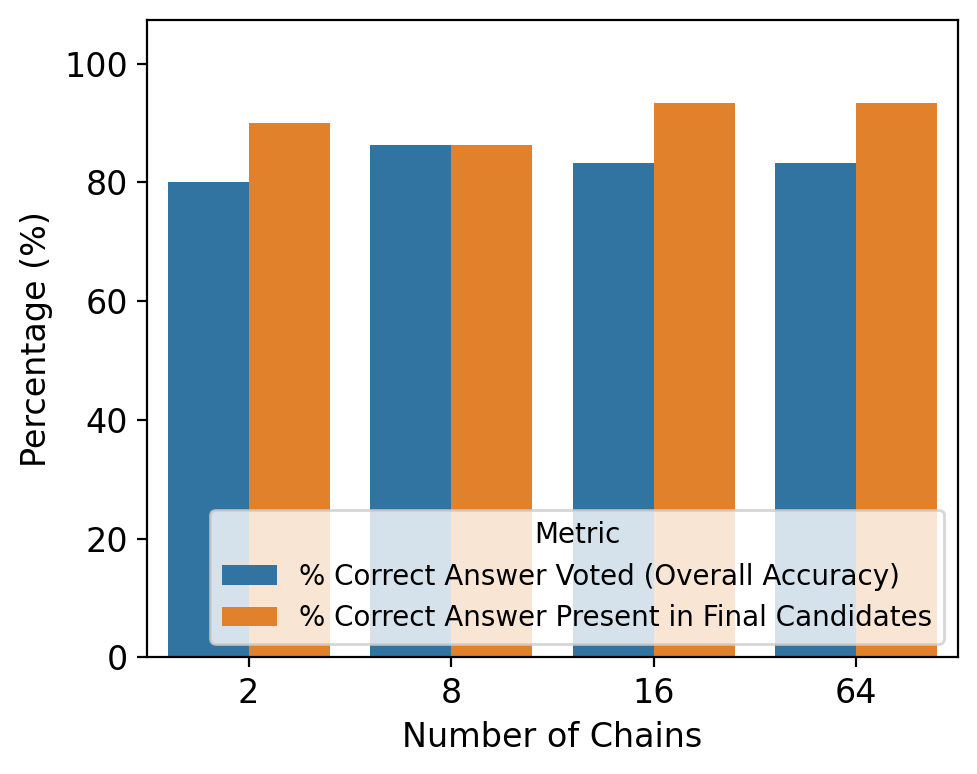

  Generating plot for QwQ-32B / aqua_rat...


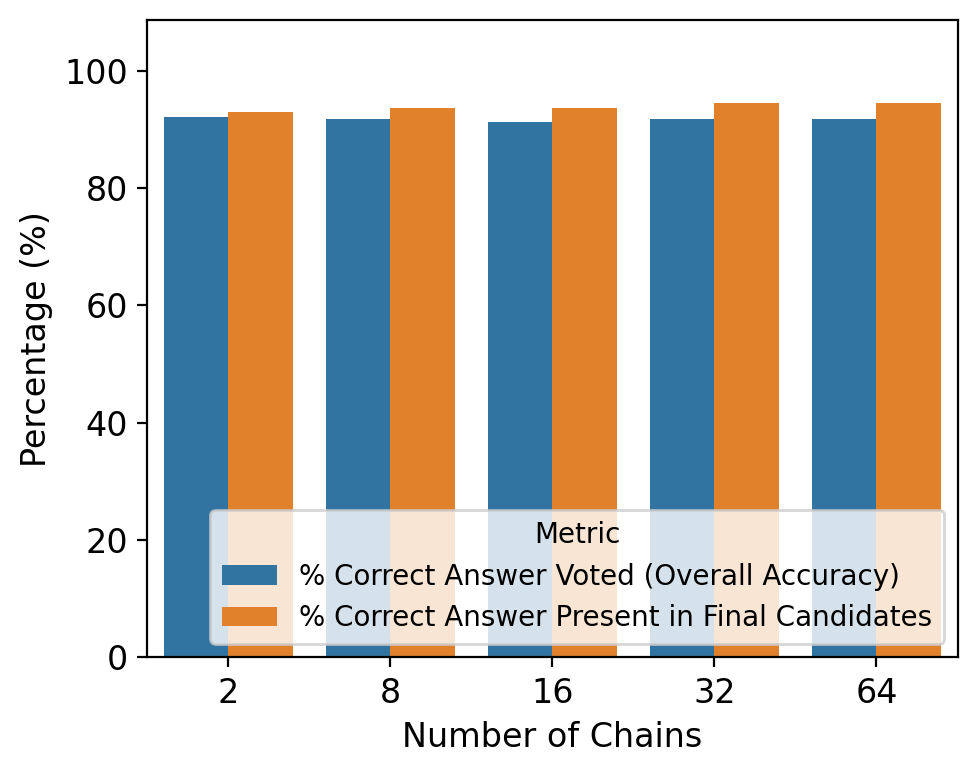

  Generating plot for QwQ-32B / gpqa_diamond...


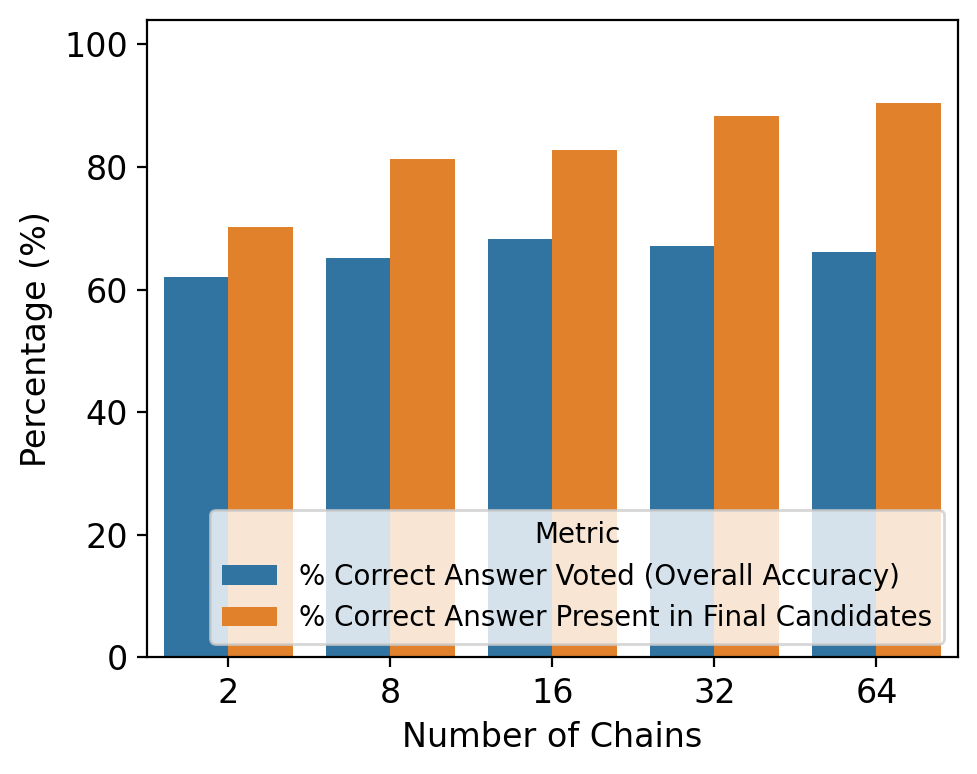

  Generating plot for QwQ-32B / hmmt...


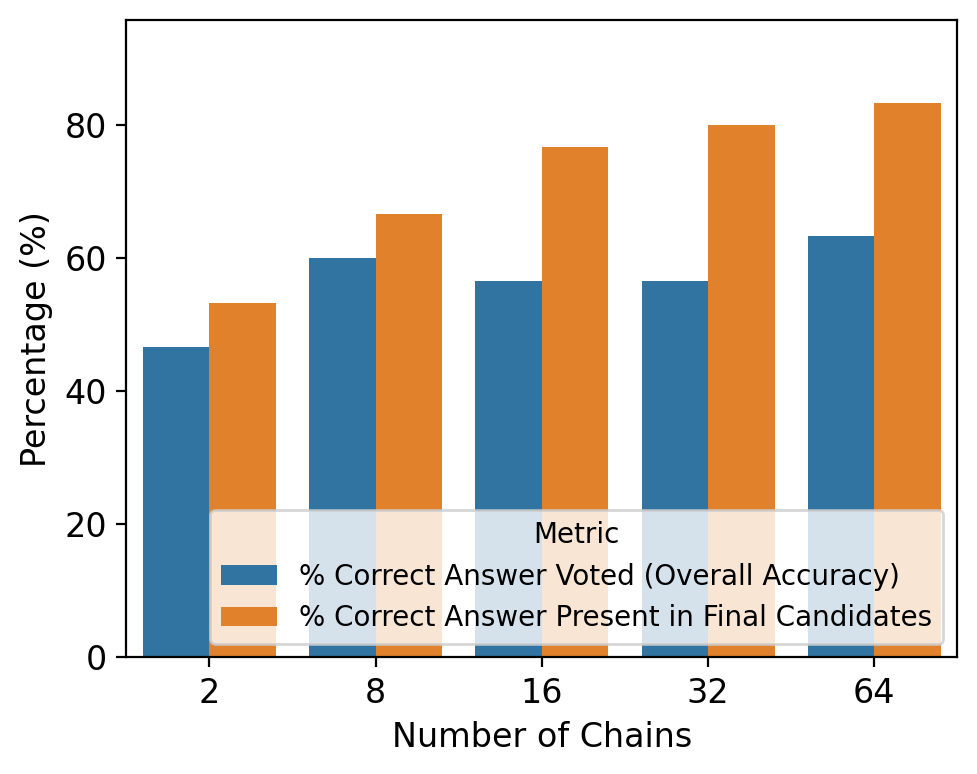

  Generating plot for R1-Distill-Qwen-14B / aime...


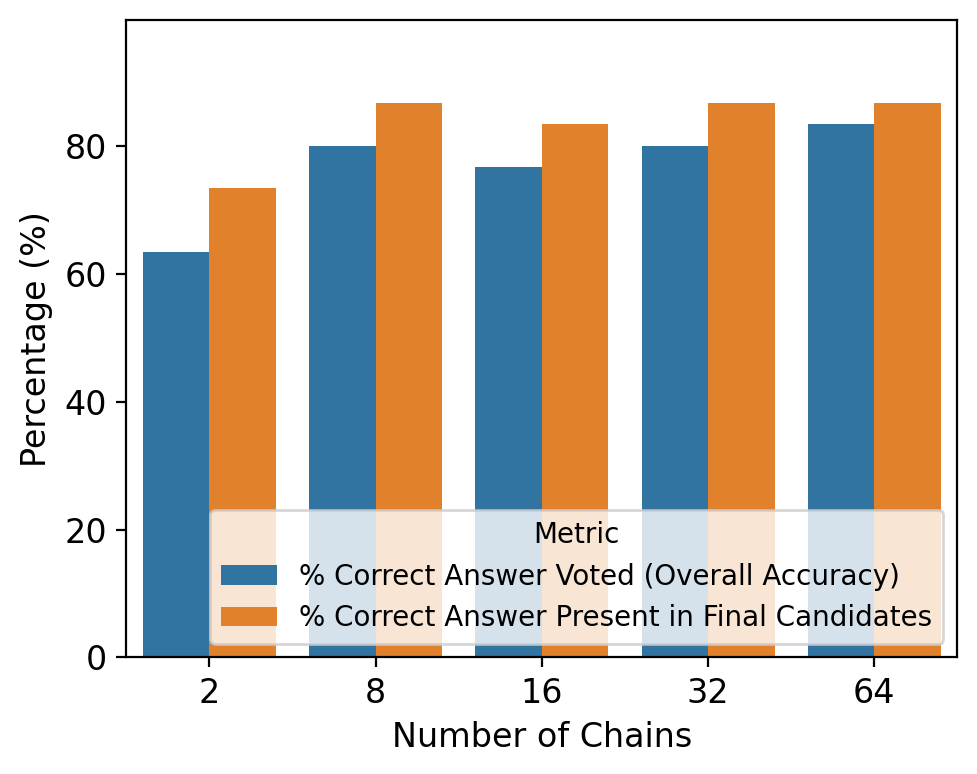

  Generating plot for R1-Distill-Qwen-14B / aqua_rat...


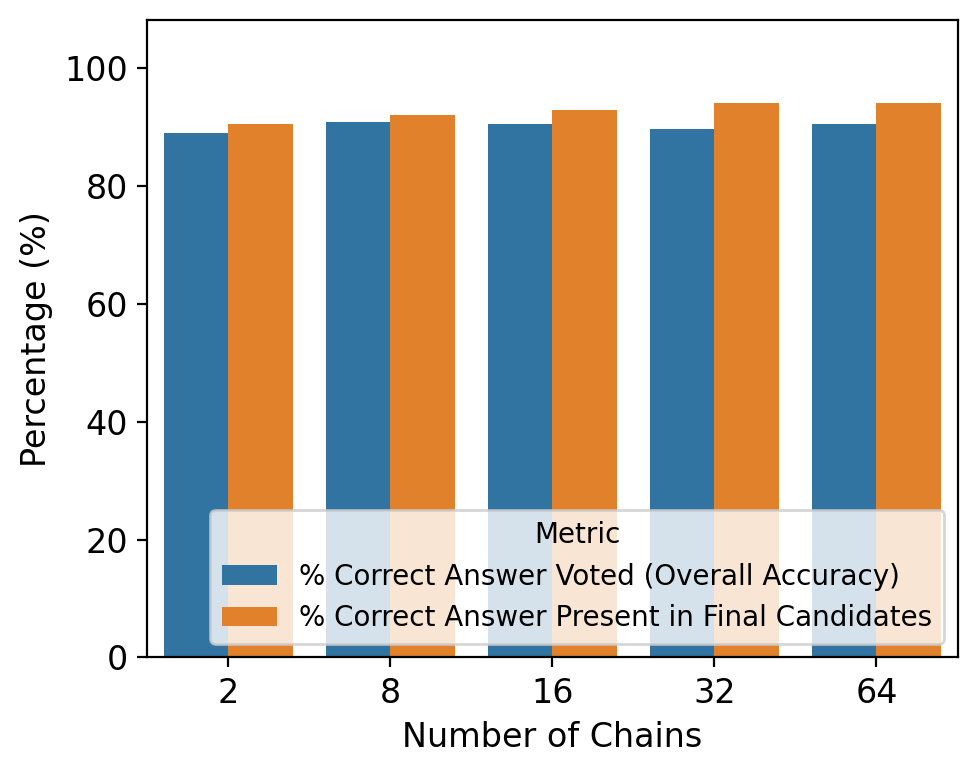

  Generating plot for R1-Distill-Qwen-14B / gpqa_diamond...


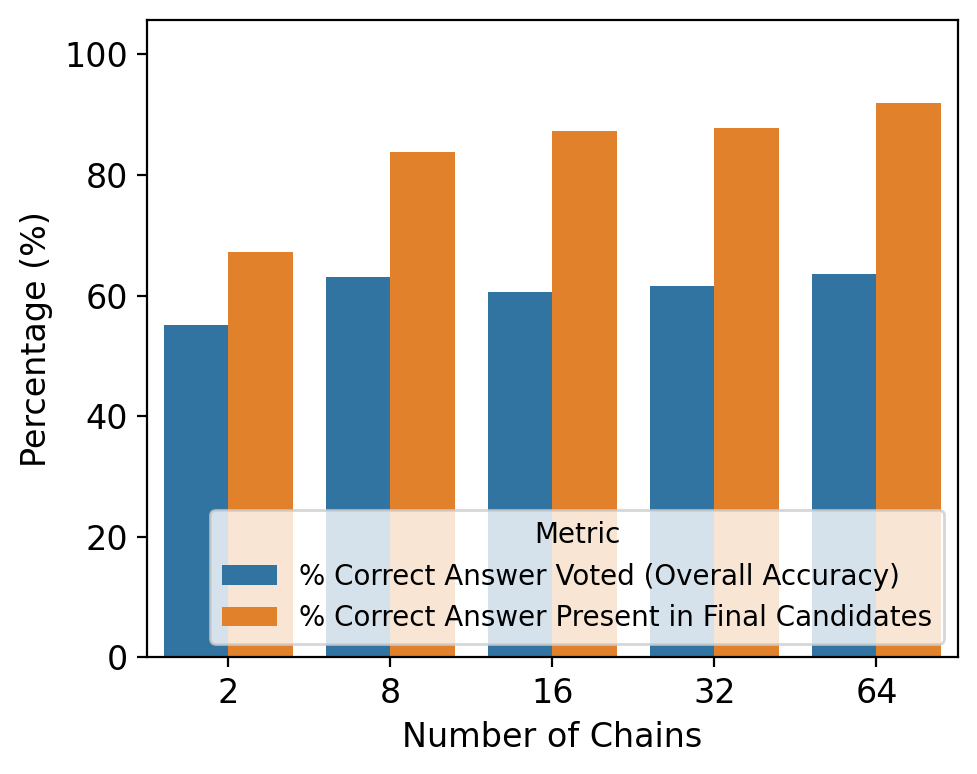

  Generating plot for R1-Distill-Qwen-14B / hmmt...


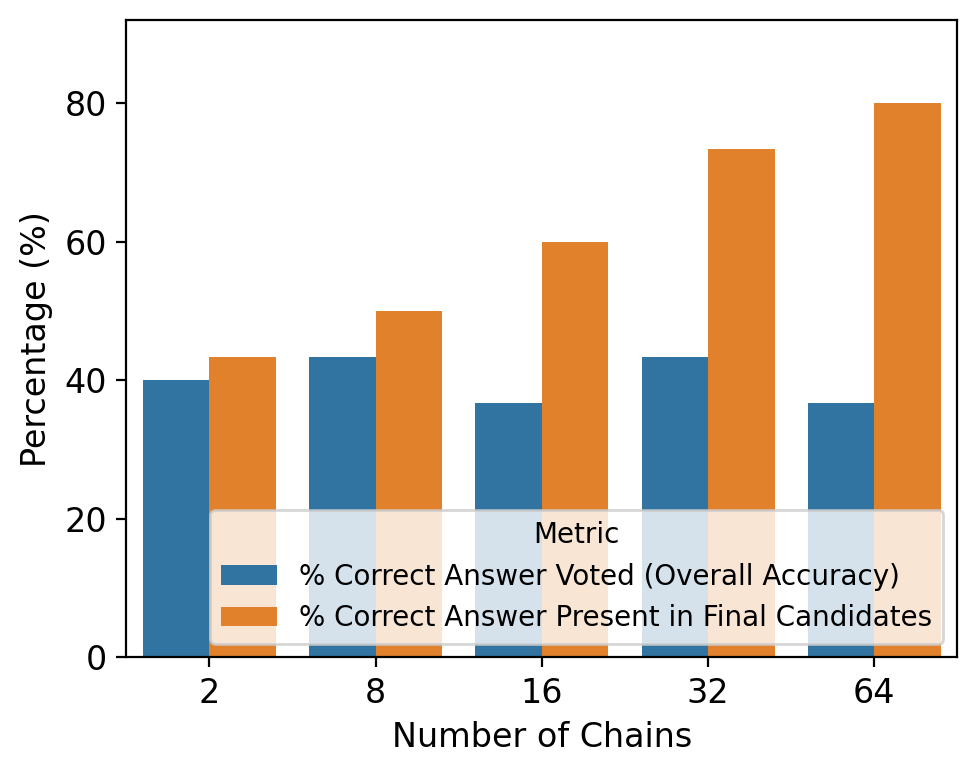


--- Plotting Complete ---


In [7]:
# --- Plotting ---

def sanitize_filename(name):
    # Replace anything that isn't alphanumeric or underscore with underscore
    return re.sub(r'[^\w\-]', '_', name)

if not df_sc_melted.empty:
    print("\n--- Generating Plots ---")

    # Iterate through each Model/Dataset combination
    for (model, dataset), group_df in df_sc_melted.groupby(['Model', 'Dataset']):
        print(f"  Generating plot for {model} / {dataset}...")

        # Ensure n_chains is treated correctly for plotting order
        group_df = group_df.sort_values(by='n_chains')

        plt.figure(figsize=(5, 4)) # Adjust figure size as needed

        # Use seaborn.barplot for grouped bars
        ax = sns.barplot(
            x='n_chains',
            y='Percentage',
            hue='Metric',
            data=group_df,
            palette='tab10' # You can choose a different palette
        )

        # Add title and labels
        plt.xlabel('Number of Chains', fontsize=12)
        plt.ylabel('Percentage (%)', fontsize=12) # Generic label as y-axis scale varies by metric type

        # Add value annotations to bars
        for container in ax.containers:
            metric_name = container.get_label()
            # metric_type = get_format_type(metric_name) # Not used in current annotation logic

            for patch in container.patches:
                height = patch.get_height()
                if pd.notna(height):
                    annotation_text = f"{height:.1f}%" # All metrics are percentages here
                    x_pos = patch.get_x() + patch.get_width() / 2.
                    y_pos = height
                    # Uncomment and adjust if you want annotations
                    # ax.annotate(annotation_text,
                    #             (x_pos, y_pos),
                    #             ha='center',
                    #             va='bottom',
                    #             xytext=(0, 3), # Offset text 3 points upwards
                    #             textcoords='offset points',
                    #             fontsize=7)

        # Improve layout
        plt.xticks(rotation=0, fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Metric', loc='lower right') # Changed to loc='lower right' for potentially better placement

        # Adjust y-axis limits for clarity
        max_val = group_df['Percentage'].max()
        # Ensure y_lim starts from 0, and give a bit of padding at the top.
        # Handle cases where max_val might be NaN or 0.
        current_ylim_top = plt.gca().get_ylim()[1]
        padding = 0.15 * (max_val if pd.notna(max_val) and max_val > 0 else current_ylim_top)
        new_ylim_top = (max_val if pd.notna(max_val) else 0) + padding
        if new_ylim_top <= 0 : # if max_val is 0 or negative (unlikely for percentage)
            new_ylim_top = 1 # Default top if no data or all zero
        plt.ylim(0, new_ylim_top if new_ylim_top > plt.ylim()[0] else current_ylim_top)


        plt.tight_layout()

        # Save the plot
        sanitized_model = sanitize_filename(model)
        sanitized_dataset = sanitize_filename(dataset)
        plot_filename_str = f"{sanitized_model}_{sanitized_dataset}_sc_ideal_vs_actual_acc.png"

        # Use pathlib methods for directory creation and path construction
        PLOTS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True) # Ensures directory exists
        plot_path = PLOTS_OUTPUT_DIR / plot_filename_str   # Creates a Path object

        # print(f"    Saving plot to: {plot_path} (Type: {type(plot_path)})") # For debugging
        plt.savefig(plot_path, dpi=300)

        plt.show()
else:
    print("\nNo data to plot.")

print("\n--- Plotting Complete ---")